In [1]:
import lumicks.pylake as lk
from skimage.filters import threshold_otsu
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from skimage.exposure import match_histograms
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from tkinter import filedialog as fd
import numpy as np
import os
from os.path import join
from shutil import move

In [2]:
folder = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/RNAinFUS_PaperFigures/Fig1_system design/CTRAP"
os.chdir(folder)
fname = "20230502-120219 Scan NOTAG13.h5"
lkfile = lk.File(fname)
name = list(lkfile.scans)[0]
video_blue = lkfile.scans[name].get_image("blue")

um_per_pixel = lkfile.scans[name].pixelsize_um[0]
print("pixel size", um_per_pixel)

ref_img = video_blue[0]
video_corrected = np.stack(
    [match_histograms(img, ref_img) for img in video_blue[:-1]], axis=0
)
video_denoised = gaussian_filter(video_corrected, sigma=1)
threshold = threshold_otsu(video_denoised, nbins=30)
video_mask = video_denoised > threshold

pixel size 0.1


In [3]:
# Import data: Force in the x direction (pN)
force2x = lkfile["Force HF"]["Force 2x"]

# Downsample forces for plotting
sample_rate = force2x.sample_rate
downsampled_rate = 20  # Hz
downsample_ratio = int(sample_rate / downsampled_rate)

force2x_downsamp = force2x.downsampled_by(downsample_ratio)
time_downsamp = (
    force2x_downsamp.timestamps - force2x_downsamp.timestamps[0]
) / 1e9  # convert from ns to s
F_toplot_fN = (force2x_downsamp.data - force2x_downsamp.data.min()) * 1e3

condensate_size_um2 = np.array([mask.sum() * um_per_pixel**2 for mask in video_mask])
t_for_size = np.linspace(time_downsamp[0], time_downsamp[-1], len(condensate_size_um2))

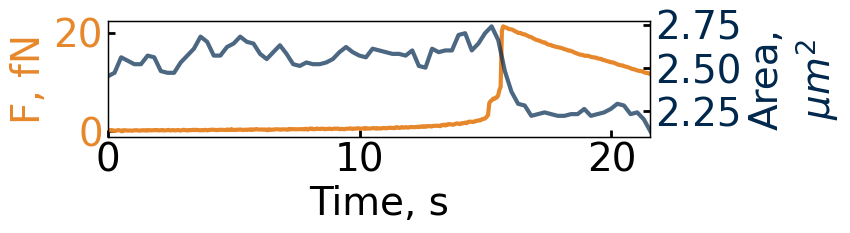

In [9]:
fontsize = 28
relative_ylabel = 0.25
fig, ax1 = plt.subplots(figsize=(7, 1.5))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# set up x axis fist
ax1.set_xlabel("Time, s", fontsize=fontsize)
ax1.tick_params(
    axis="x",
    labelcolor="black",
    labelsize=fontsize,
    direction="in",
    length=5,
    width=2,
)
# plot and setup left yaxis (ax1)
color = "#E7872B"
ax1.set_ylabel(
    "F, fN",
    color=color,
    fontsize=fontsize,
    # y=relative_ylabel,
)
ax1.plot(time_downsamp, F_toplot_fN, color=color, lw=3)
ax1.tick_params(
    axis="y",
    labelcolor=color,
    labelsize=fontsize,
    direction="in",
    length=5,
    width=2,
)
# plot and setup right yaxis (ax2)
color = "#00274C"  # blue
ax2.set_ylabel(
    "Area,\n$\mu$$m^2$",
    color=color,
    fontsize=fontsize,
    # y=relative_ylabel,
)  # we already handled the x-label with ax1
ax2.plot(
    t_for_size,
    condensate_size_um2,
    color=color,
    lw=3,
    alpha=0.7,
)
ax2.tick_params(
    axis="y",
    labelcolor=color,
    labelsize=fontsize,
    direction="in",
    length=5,
    width=2,
)

plt.gca().spines[:].set_linewidth(1)
plt.xlim(0, time_downsamp[-1])

fname_png = "Fig1_CTRAP_curve.png"
plt.savefig(
    fname_png,
    format="png",
    bbox_inches="tight",
    dpi=600,
)

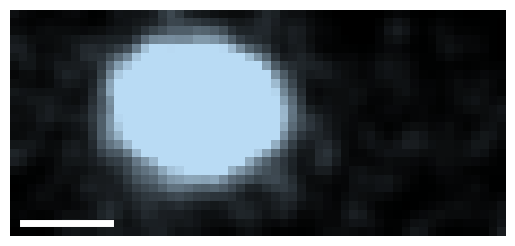

In [5]:
img_toplot = video_denoised[63]
vmin, vmax = np.percentile(img_toplot, (0.5, 85))
fname_save = "fused.png"

cmap_color_start = "black"
cmap_color_end = "#B9DBF4"
cmap_name = "dark2cyan"
cmap = clr.LinearSegmentedColormap.from_list(
    cmap_name,
    [cmap_color_start, cmap_color_end],
    N=200,
)

plt.figure()
plt.imshow(
    img_toplot,
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
)

# plot scale bar
scalebar_length_um = 1
scalebar_length_pxl_x = scalebar_length_um / um_per_pixel
plt.plot(
    [45, 45 + scalebar_length_pxl_x],
    [24, 24],
    "-",
    color="white",
    lw=5,
)

plt.gca().invert_xaxis()
plt.axis("scaled")
plt.axis("off")
plt.savefig(fname_save, dpi=300, format="png", bbox_inches="tight")
plt.show()